<a href="https://colab.research.google.com/github/samyon7/MyPrivate_MachineLearning/blob/master/Simple_Prediction_With_Time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --no-check-certificate \
  https://raw.githubusercontent.com/agungtriu/Belajar-Pengembangan-Machine-Learning/master/Submission/Submission%202%20Time%20Series/HR2019-04-10.csv \
  -O /content/HR2019-04-10.csv

--2021-02-11 08:46:59--  https://raw.githubusercontent.com/agungtriu/Belajar-Pengembangan-Machine-Learning/master/Submission/Submission%202%20Time%20Series/HR2019-04-10.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175489 (171K) [text/plain]
Saving to: ‘/content/HR2019-04-10.csv’

/content/HR2019-04- 100%[===================>] 171.38K  --.-KB/s    in 0.03s   

2021-02-11 08:47:00 (5.94 MB/s) - ‘/content/HR2019-04-10.csv’ saved [175489/175489]



In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

data_train = pd.read_csv('HR2019-04-10.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    10900 non-null  object
 1   value   10900 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 170.4+ KB


In [ ]:
data_train['value']= data_train['value'].astype(np.float32)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    10900 non-null  object 
 1   value   10900 non-null  float32
dtypes: float32(1), object(1)
memory usage: 127.9+ KB


In [ ]:
data_train.isnull().sum()

time     0
value    0
dtype: int64

In [ ]:
times = data_train['time'].values
value  = data_train['value'].values

In [24]:
len(value)

10900

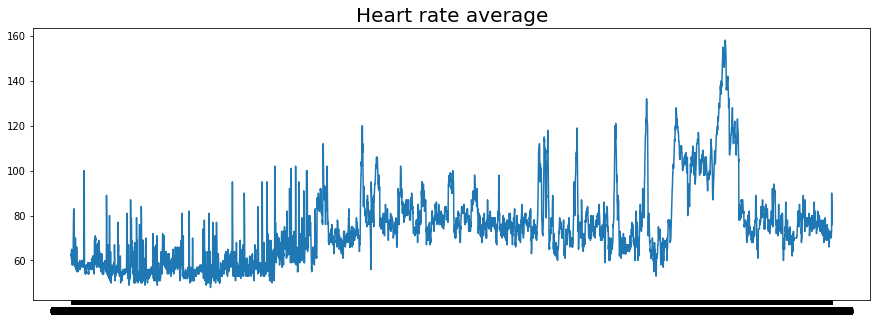

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(times, value)
plt.title('Heart rate average',
          fontsize=20);

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(value, window_size=60, batch_size=200, shuffle_buffer=1000)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(LSTM(60)),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<10):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-05, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500, callbacks=[callbacks])

Epoch 1/500
55/55 [==============================] - 7s 29ms/step - loss: 65.7721 - mae: 66.2721
Epoch 2/500
55/55 [==============================] - 2s 31ms/step - loss: 65.7173 - mae: 66.2173
Epoch 3/500
55/55 [==============================] - 2s 31ms/step - loss: 65.6111 - mae: 66.1111
Epoch 4/500
55/55 [==============================] - 2s 31ms/step - loss: 65.5150 - mae: 66.0150
Epoch 5/500
55/55 [==============================] - 2s 32ms/step - loss: 65.4354 - mae: 65.9354
Epoch 6/500
55/55 [==============================] - 2s 31ms/step - loss: 65.3506 - mae: 65.8506
Epoch 7/500
55/55 [==============================] - 2s 32ms/step - loss: 65.2869 - mae: 65.7869
Epoch 8/500
55/55 [==============================] - 2s 31ms/step - loss: 65.1940 - mae: 65.6940
Epoch 9/500
55/55 [==============================] - 2s 31ms/step - loss: 65.1161 - mae: 65.6161
Epoch 10/500
55/55 [==============================] - 2s 31ms/step - loss: 65.0322 - mae: 65.5322
Epoch 11/500
55/55 [=========

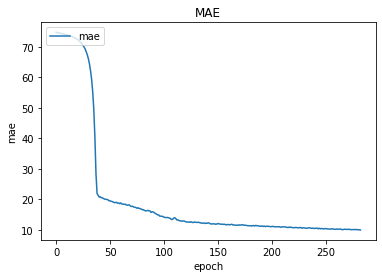

In [21]:
plt.plot(history.history['mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['mae'], loc='upper left')
plt.show()